In [14]:
import torch
from diffusers import DiffusionPipeline, AutoencoderTiny

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16
)
pipe.vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", torch_dtype=torch.float16)
# pipe = pipe.to("cuda")
pipe = pipe.to("mps")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/envs/detection/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

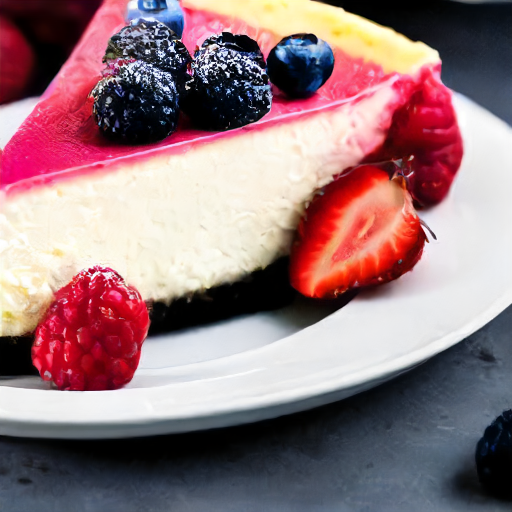

In [15]:
prompt = "slice of delicious New York-style berry cheesecake"
image = pipe(prompt, num_inference_steps=25).images[0]
image

In [29]:
from PIL import Image
from torchvision import transforms
import torch

# Preprocessing transforms to resize, normalize, and convert to tensor
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # or the resolution your model expects
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Convert the image 
input_image = image
print(input_image.size, input_image.mode)
input_tensor = preprocess(input_image).unsqueeze(0).to("mps", torch.float16)

# Get the latent representation from the VAE
latent_representation = pipe.vae.encode(input_tensor).latents # or .mode() for deterministic
print(latent_representation.dtype, latent_representation.shape)


(512, 512) RGB None
torch.float16 torch.Size([1, 4, 64, 64])


torch.Size([1, 3, 512, 512])


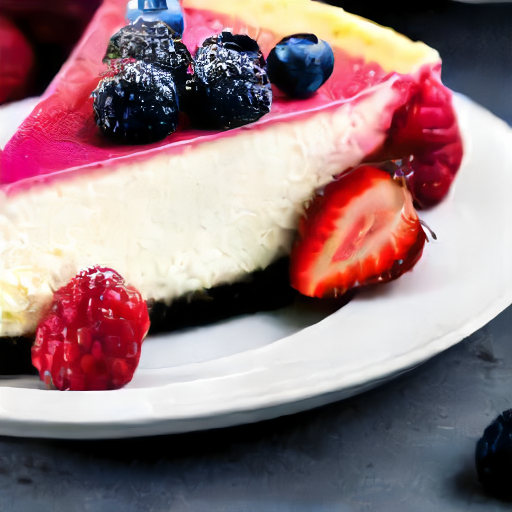

In [17]:
reconstructed_image = pipe.vae.decode(latent_representation)
# reconstructed_image is of type DecoderOutput, convert to image
reconstructed_image_tensor = reconstructed_image.sample
                                   
# Denormalize the reconstructed image
denormalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
reconstructed_image_tensor = denormalize(reconstructed_image_tensor).clamp(0, 1)

print(reconstructed_image_tensor.shape) # torch.Size([1, 3, 512, 512])

# Convert the tensor to an image
reconstructed_image = transforms.ToPILImage()(reconstructed_image_tensor[0].cpu())
reconstructed_image

In [24]:
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Convert tensors back to images (detach from GPU, and convert to CPU)
# input_image_np = input_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
# reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

input_image_np = input_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
reconstructed_image_np = reconstructed_image_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

print(input_image_np.shape) # (512, 512, 3)
print(reconstructed_image_np.shape) # (512, 512, 3)

# Compute pixel-wise difference (L2 loss)
pixel_difference = F.mse_loss(input_tensor, reconstructed_image_tensor)

# Compute SSIM
ssim_score = ssim(
    input_image_np, reconstructed_image_np, 
    win_size=7,  # Or try a smaller value if necessary
    channel_axis=-1,  # Correctly specify the channel axis for RGB images
    data_range=1.0  # Since input is normalized in the range [0, 1]
)

print(f"Pixel-wise difference: {pixel_difference.item()}")
print(f"SSIM score: {ssim_score}")


(512, 512, 3)
(512, 512, 3)
Pixel-wise difference: 0.384765625
SSIM score: 0.18893878161907196
